# Exploration of Data and Visualizations of Data

### Explores the data from 2023-2024 with zones

##### First load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
df = pd.read_parquet('../data/raw_data/yellow_23-24_data.parquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,1,2023-06-01 00:08:48,2023-06-01 00:29:41,1.0,3.40,1.0,N,140,238,1,21.9,3.50,0.5,6.70,0.0,1.0,33.60,2.5,0.00,NaN
1,1,2023-06-01 00:15:04,2023-06-01 00:25:18,0.0,3.40,1.0,N,50,151,1,15.6,3.50,0.5,3.00,0.0,1.0,23.60,2.5,0.00,NaN
2,1,2023-06-01 00:48:24,2023-06-01 01:07:07,1.0,10.20,1.0,N,138,97,1,40.8,7.75,0.5,10.00,0.0,1.0,60.05,0.0,1.75,NaN
3,2,2023-06-01 00:54:03,2023-06-01 01:17:29,3.0,9.83,1.0,N,100,244,1,39.4,1.00,0.5,8.88,0.0,1.0,53.28,2.5,0.00,NaN
4,2,2023-06-01 00:18:44,2023-06-01 00:27:18,1.0,1.17,1.0,N,137,234,1,9.3,1.00,0.5,0.72,0.0,1.0,15.02,2.5,0.00,NaN


##### Many of these columns we will not need. We will drop many of them. Also drop NaNs.

In [3]:
keep_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'PULocationID', 'DOLocationID']
df = df[keep_cols]

len_before = len(df)
df = df.dropna()
len_after = len(df)
print(f'Dropped {len_before - len_after} rows with missing values')
print(f'This is {100*(len_before - len_after)/len_before:.2f}% of the data')
print(f"Now we have {len(df)} rows")

Dropped 3564330 rows with missing values
This is 5.78% of the data
Now we have 58154888 rows


##### We care about the density of pickups at different locations for a certain time. Let's build this feature.

In [4]:
len_before = len(df)
df = df[(df.tpep_pickup_datetime >= pd.to_datetime('2023-01-01')) & 
        (df.tpep_pickup_datetime <= pd.to_datetime('2024-12-31'))]
len_after = len(df)
print(f'Dropped {len_before - len_after} rows outside the desired date range')
print(f"earliest date: {df.tpep_pickup_datetime.min()}")
print(f"latest date: {df.tpep_pickup_datetime.max()}")

Dropped 127 rows outside the desired date range
earliest date: 2023-01-01 00:00:05
latest date: 2024-08-01 23:51:57


##### The below cell takes pickup datetime objects and extracts the day of the week, data, and time (divided into specified intervals)

In [5]:
def build_date_time(data, minute_interval=60):
    """Build new colums for the day, date, and time.
    
        day (str): Day of the week
        date (str): Date in the format YYYY-MM-DD
        time (str): Time in the format HH:MM. Rounded to nearest minute_interval.
    """
    # Check if the column name is "pickup_datetime". If not, rename it.
    if "pickup_datetime" not in data.columns:
        if "tpep_pickup_datetime" in data.columns:
            data.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)
        else:
            raise ValueError("No column found for pickup datetime.")
    
    if "+00:00" in str(data["pickup_datetime"].iloc[0]):  # Check as string
        data["pickup_datetime"] = data["pickup_datetime"].astype(str).str.replace("+00:00", "")
    
    if " UTC" in str(data["pickup_datetime"].iloc[0]):  # Check as string
        data["pickup_datetime"] = data["pickup_datetime"].astype(str).str.replace(" UTC", "")

    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

    # Get day of the week
    data["day"] = data["pickup_datetime"].dt.day_name()

    # Get date
    data["date"] = data["pickup_datetime"].dt.date

    # Get time rounded to the nearest minute_interval - and only keep the hours and minutes
    data["time"] = data["pickup_datetime"].dt.round(f"{minute_interval}min").dt.time

    # Drop the original datetime column
    data.drop(columns=["pickup_datetime"], inplace=True)

    return data

df = build_date_time(df)
df.head()

,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,day,date,time
0,2023-06-01 00:29:41,1.0,140,238,Thursday,2023-06-01,00:00:00
1,2023-06-01 00:25:18,0.0,50,151,Thursday,2023-06-01,00:00:00
2,2023-06-01 01:07:07,1.0,138,97,Thursday,2023-06-01,01:00:00
3,2023-06-01 01:17:29,3.0,100,244,Thursday,2023-06-01,01:00:00
4,2023-06-01 00:27:18,1.0,137,234,Thursday,2023-06-01,00:00:00


##### This (below) cell creates a new feature counting the number of data points per location ID, day of the week, and time.

In [6]:
def count_pickups(data):
    """Count the number of pickups at each location ID at each time interval. 
    So one row will correspond to a location ID, day, and time. The columns will be:
        - location ID
        - count of pickups
        - day
        - time
    """    
    data = (
        data
        .groupby(['PULocationID', "day", "time"])  # Group by location ID, day, and time
        .size()                                    # Count the number of instances in each group
        .rename("pickup_count")                    # Rename the Series to pickup_count
        .reset_index()                             # Convert index columns back into regular columns
        )
    return data

df = count_pickups(df)
df.head()

,PULocationID,day,time,pickup_count
0,1,Friday,00:00:00,3
1,1,Friday,01:00:00,4
2,1,Friday,02:00:00,7
3,1,Friday,03:00:00,8
4,1,Friday,04:00:00,15


##### Let's see how this has affected the data

In [7]:
df.describe()

,PULocationID,pickup_count
count,38994.000000,38994.000000
mean,134.047520,1491.377161
std,77.156763,4225.835092
min,1.000000,1.000000
25%,67.000000,7.000000
50%,136.000000,28.000000
75%,201.000000,227.000000
max,265.000000,44393.000000


##### So we have condensed our dataset from 58 million points to about 38 thousand. Now training a model should be more tractable.

##### Let's visualize!

##### These are the distinct taxi zones:

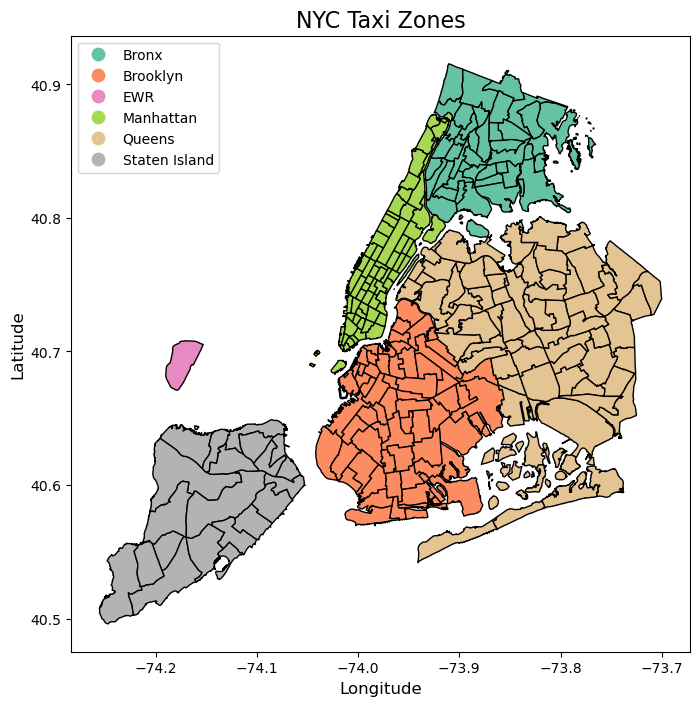

In [8]:
taxi_zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
taxi_zones = taxi_zones.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(8, 8))
taxi_zones.plot(column='borough', cmap='Set2', ax=ax, edgecolor='black', legend=True, legend_kwds={'loc': 'upper left'})

ax.set_title('NYC Taxi Zones', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

##### These are the zones color coded by pickup density (across all days)

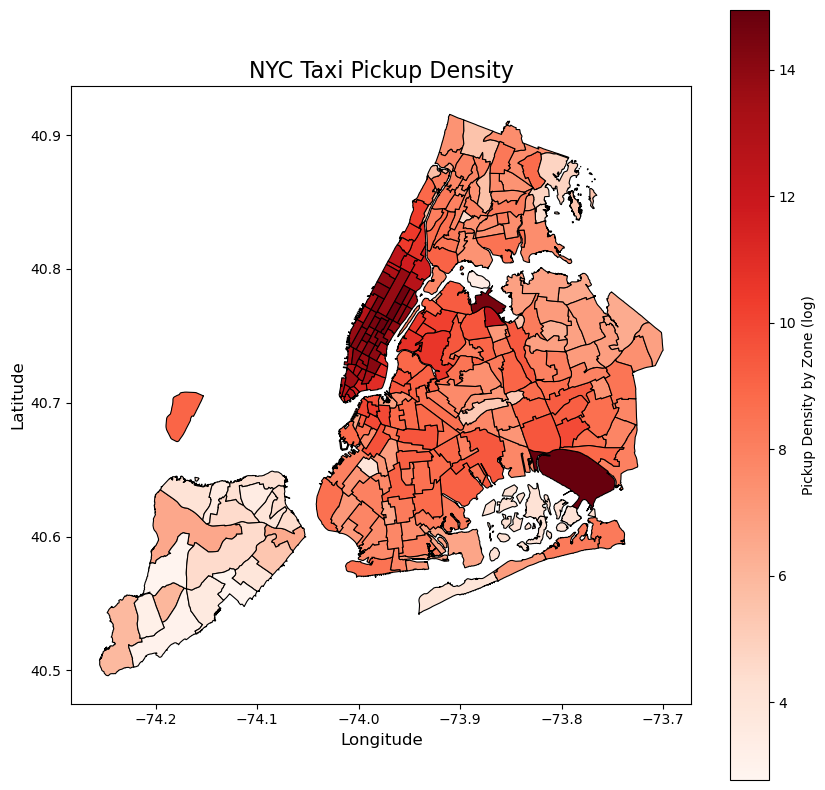

In [9]:
# Aggregate data to calculate total pickups per zone
pickup_density = df.groupby('PULocationID')['pickup_count'].sum().reset_index()  # Sum the pickup counts for each zone

# Load taxi zones shapefile
taxi_zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
taxi_zones = taxi_zones.to_crs("EPSG:4326")

# Merge the aggregated data with the taxi zones GeoDataFrame
taxi_zones = taxi_zones.merge(pickup_density, left_on='LocationID', right_on='PULocationID', how='left')

# log transform the pickup count to make the choropleth map more readable
taxi_zones['pickup_count'] = np.log1p(taxi_zones['pickup_count'])

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
taxi_zones.plot(
    column='pickup_count',  # Column to color-code
    cmap='Reds',  # Color map
    linewidth=0.8,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Pickup Density by Zone (log)", 'orientation': "vertical"}
)

ax.set_title('NYC Taxi Pickup Density', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()


##### Let's make 7 plots (one for each day of the week) displaying the density

/var/folders/lc/6n3k9ht52fxdnv5mqyw8tngh0000gn/T/ipykernel_84579/1157324324.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar and title


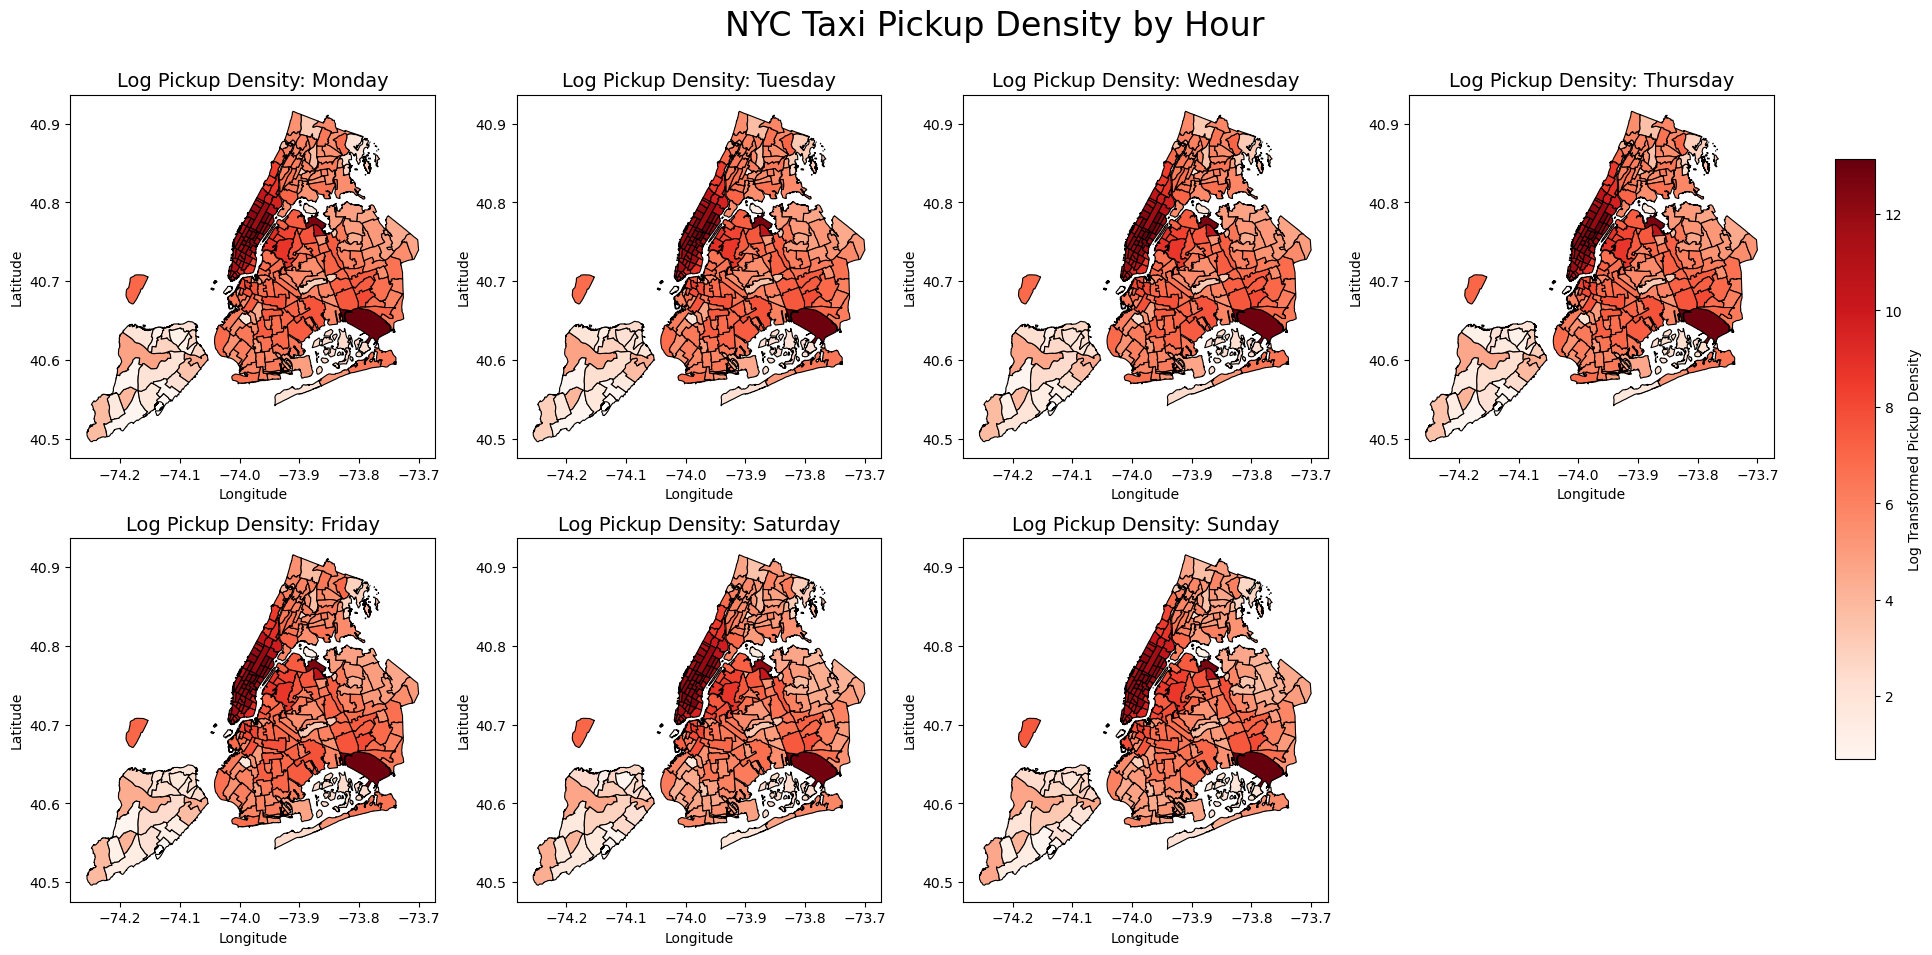

In [10]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define the figure size and layout for subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Remove the last subplot (since we only need 7)
fig.delaxes(axes[-1])  # Delete the 8th subplot (bottom-right empty slot)

# First pass: calculate global min and max density for color normalization
min_density = float('inf')
max_density = float('-inf')

for day in days:
    day_data = df[df['day'] == day]
    day_pickups = day_data.groupby('PULocationID')['pickup_count'].sum().reset_index()
    day_pickups['density'] = np.log1p(day_pickups['pickup_count'])  # Log transform
    min_density = min(min_density, day_pickups['density'].min())
    max_density = max(max_density, day_pickups['density'].max())

# Second pass: plot each day with consistent color scaling
for i, day in enumerate(days):
    day_data = df[df['day'] == day]
    
    # Aggregate pickup counts by zone
    day_pickups = day_data.groupby('PULocationID')['pickup_count'].sum().reset_index()
    day_pickups.rename(columns={'pickup_count': 'density'}, inplace=True)
    
    # Merge with the taxi zones GeoDataFrame
    day_zones = taxi_zones.merge(day_pickups, how='left', left_on='LocationID', right_on='PULocationID')
    day_zones['density'].fillna(0, inplace=True)  # Fill missing values with 0

    day_zones['density'] = np.log1p(day_zones['density'])  # Log transform the density
    
    # Plot the map for the current day
    ax = axes[i]
    day_zones.plot(
        column='density',
        cmap='Reds',
        linewidth=0.8,
        ax=ax,
        edgecolor='black',
        legend=False,
        vmin=min_density,  # Use global min density
        vmax=max_density   # Use global max density
    )
    ax.set_title(f'Log Pickup Density: {day}', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min_density, vmax=max_density))
fig.colorbar(sm, cax=cbar_ax, label='Log Transformed Pickup Density', orientation='vertical')

# Add a suptitle and adjust layout
plt.suptitle('NYC Taxi Pickup Density by Hour', fontsize=24, y=0.95)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar and title
plt.show()

##### They all look more or less the same, lol. 

##### What about for different times of the day? 
Let's explore this by choosing Monday (can easily choose another day) and make 24 plots, one for each hour of the day.

/var/folders/lc/6n3k9ht52fxdnv5mqyw8tngh0000gn/T/ipykernel_84579/2368643323.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar and title


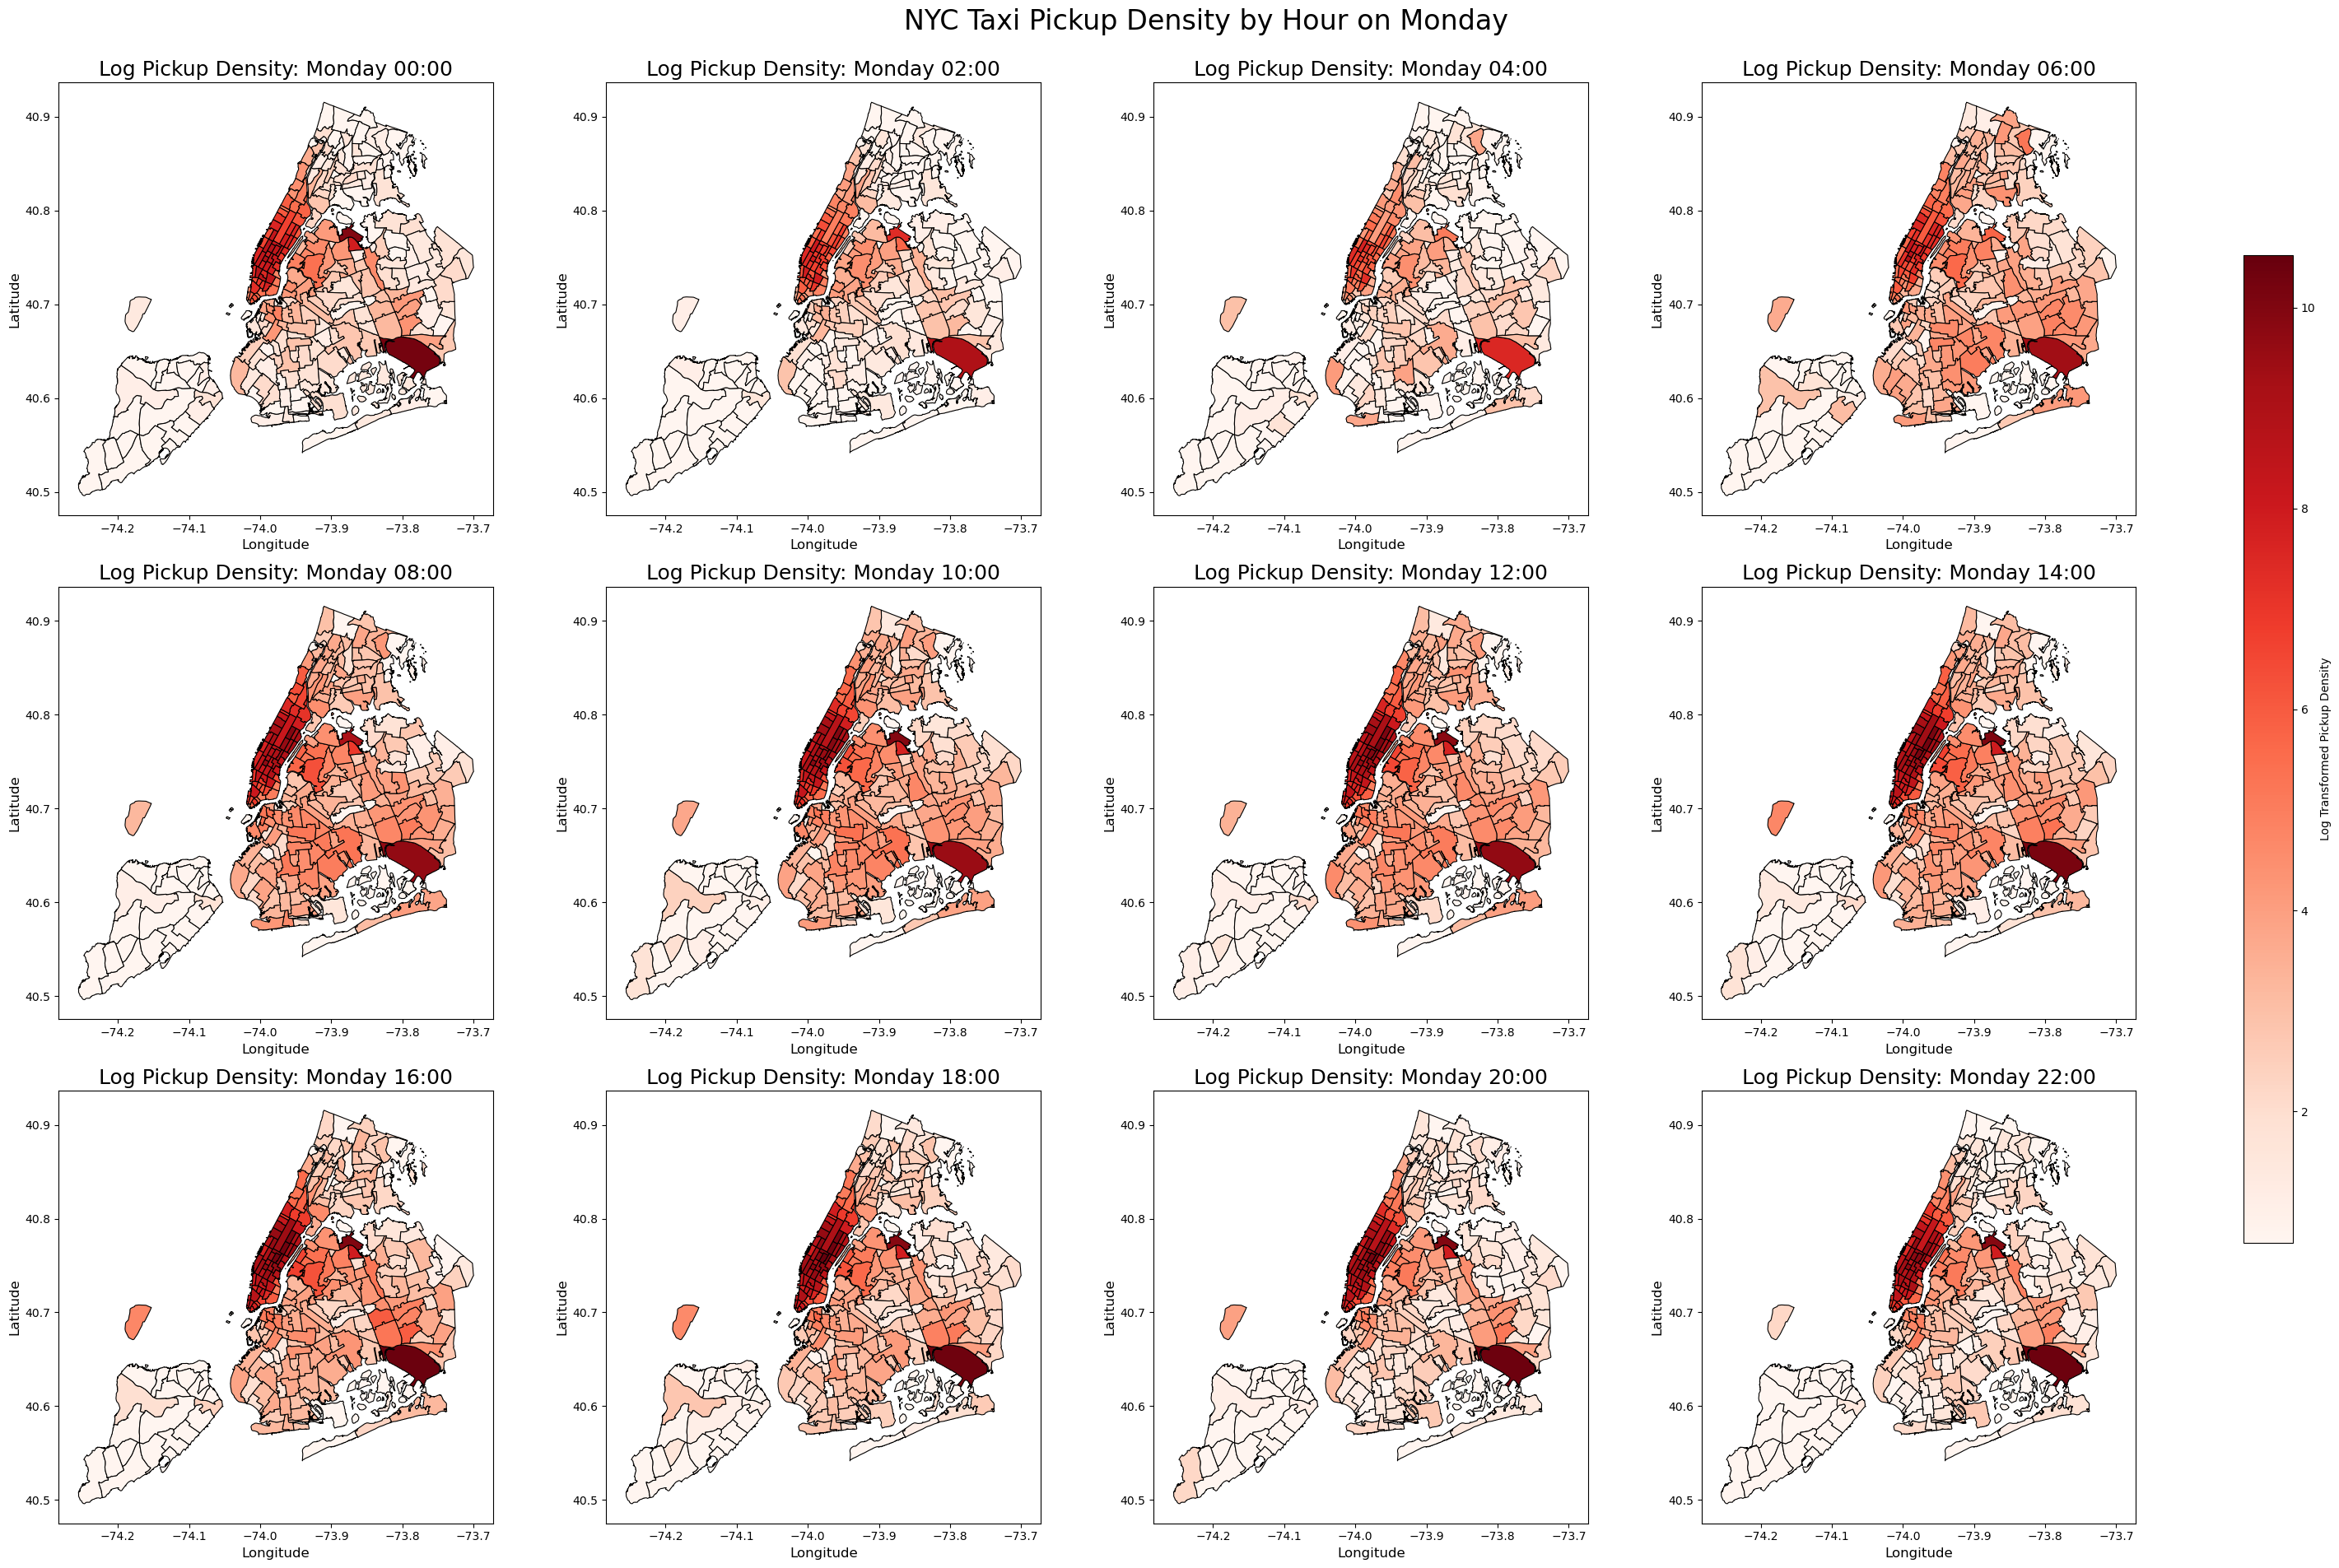

In [11]:
day = 'Monday'
day_data = df[df['day'] == day]

# Define the figure size and layout for subplots
fig, axes = plt.subplots(3, 4, figsize=(30, 20))
axes = axes.flatten()

# Define color scaling based on all hours for consistent comparison
min_density = float('inf')
max_density = float('-inf')

# First pass: calculate global min and max density for color normalization
for i in range(12):
    hour_data = day_data[day_data['time'].apply(lambda x: x.hour) == 2 * i]
    hour_pickups = hour_data.groupby('PULocationID')['pickup_count'].sum().reset_index()
    hour_pickups['density'] = np.log1p(hour_pickups['pickup_count'])  # Log transform
    min_density = min(min_density, hour_pickups['density'].min())
    max_density = max(max_density, hour_pickups['density'].max())

# Second pass: plot each hour
for i in range(12):
    # Filter data for the current hour
    hour_data = day_data[day_data['time'].apply(lambda x: x.hour) == 2 * i]
    
    # Aggregate pickup counts by zone
    hour_pickups = hour_data.groupby('PULocationID')['pickup_count'].sum().reset_index()
    hour_pickups.rename(columns={'pickup_count': 'density'}, inplace=True)
    
    # Merge with the taxi zones GeoDataFrame
    hour_zones = taxi_zones.merge(hour_pickups, how='left', left_on='LocationID', right_on='PULocationID')
    hour_zones['density'].fillna(0, inplace=True)  # Fill missing values with 0

    # Log transform the density
    hour_zones['density'] = np.log1p(hour_zones['density'])

    # Plot the map for the current hour
    ax = axes[i]
    hour_zones.plot(
        column='density',
        cmap='Reds',
        linewidth=0.8,
        ax=ax,
        edgecolor='black',
        legend=False,
        vmin=min_density,
        vmax=max_density  # Consistent color scaling
    )

    # Add titles and labels
    ax.set_title(f'Log Pickup Density: {day} {2 * i:02}:00', fontsize=18)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

# Add a single colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min_density, vmax=max_density))
fig.colorbar(sm, cax=cbar_ax, label='Log Transformed Pickup Density', orientation='vertical')

# Add a suptitle and adjust layout
plt.suptitle(f'NYC Taxi Pickup Density by Hour on {day}', fontsize=24, y=0.95)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Leave space for the colorbar and title
plt.show()


### Now let's prepare for some analysis/modeling

#### As we are aiming to predict continuous densities throughout the day, this is a regression problem. This means that we need to encode any and all non-numerical values. 
##### Let's take a look again at what data we are using to predict

In [12]:
df.head()

,PULocationID,day,time,pickup_count
0,1,Friday,00:00:00,3
1,1,Friday,01:00:00,4
2,1,Friday,02:00:00,7
3,1,Friday,03:00:00,8
4,1,Friday,04:00:00,15


### Slight correction.
I noticed that some of the location IDs are all actually the same location (like 103, 104, and 105). Said differently, there is redundancy in location IDs, so we condense them here.

In [13]:
df.loc[df['PULocationID'].isin([104, 105]), 'PULocationID'] = 103
df.loc[df['PULocationID'] == 57, 'PULocationID'] = 56

# There is also data that is unknown or outside of NYC (264, 265). We drop these.
df = df[~df['PULocationID'].isin([264, 265])]

### Conversion.
#### PULocationID is currently categorical data (even though they are technically encoded as numbers). Everything could be one-hot encoded, but this would likely result in really high dimensionality as there are so many location IDs (get exact number). We can instead convert the zone labels as latitude and longitude pairs.

#### Day. Since there are 7 days of the week, we can avoid one-hot encoding them and instead use cyclical encoding. This method (find a source that discusses this) is better for cyclical data like days of the week because it recognizes that Sunday is close to Monday (as opposed to a simple one-hot encoding or assigning labels 1-7). To completely represent the day, we will represent a day with both sine and cosine functions. Assuming 0 is Sunday and 6 is saturday, we will define the encodings as day sine $= \sin\left(\frac{2\pi}{7}\right)$ and day cosine $= \cos\left(\frac{2\pi}{7}\right)$.

#### Time. We can do a similar for time (as it is also cyclical), just dividing by b instead of 7 (where b = number of minute intervals).

#### Let's do these one at a time. Starting with location IDs. We will choose a latitude and longitude based off the center of zone.

In [14]:
zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')

# Project to a suitable coordinate system for New York City
# EPSG:2263 is New York State Plane Long Island
zones = zones.to_crs("EPSG:2263")

# Calculate centroids
zones['centroid'] = zones.geometry.centroid

# Project centroids back to WGS84 (EPSG:4326) for lat/lon coordinates
zones['centroid'] = zones['centroid'].to_crs("EPSG:4326")

zones['lon'] = zones['centroid'].x
zones['lat'] = zones['centroid'].y

zones = zones[['LocationID', 'lon', 'lat']]
df = df.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')

df = df.drop(columns=['LocationID'])

In [15]:
df.head()

,PULocationID,day,time,pickup_count,lon,lat
0,1,Friday,00:00:00,3,-74.174002,40.69183
1,1,Friday,01:00:00,4,-74.174002,40.69183
2,1,Friday,02:00:00,7,-74.174002,40.69183
3,1,Friday,03:00:00,8,-74.174002,40.69183
4,1,Friday,04:00:00,15,-74.174002,40.69183


#### That worked!

#### Now let's do cyclical encodings of day and time

In [16]:
def sin_transform(data, column, period):
    """Apply a sin transformation to a column to encode periodicity.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the column to transform.
        column (str): The name of the column to transform.
        period (int): The period of the periodicity.
        
    Returns:
        pd.DataFrame: The DataFrame with the transformed column.
    """
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / period)
    return data

def cos_transform(data, column, period):
    """Apply a cos transformation to a column to encode periodicity.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the column to transform.
        column (str): The name of the column to transform.
        period (int): The period of the periodicity.
        
    Returns:
        pd.DataFrame: The DataFrame with the transformed column.
    """
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / period)
    return data

# Need to convert the time to a number from datetime format to apply the sin and cos transformations
df['time'] = df['time'].apply(lambda x: x.hour + x.minute/60)
df.head()

,PULocationID,day,time,pickup_count,lon,lat
0,1,Friday,0.0,3,-74.174002,40.69183
1,1,Friday,1.0,4,-74.174002,40.69183
2,1,Friday,2.0,7,-74.174002,40.69183
3,1,Friday,3.0,8,-74.174002,40.69183
4,1,Friday,4.0,15,-74.174002,40.69183


#### I realized that we need to convert the time column from the datetime format to floats. Now let's apply the transforms and also drop the old categorical data. 
##### Before that though, we might want to keep a dictionary of (lat,long) ids -> location IDs

In [17]:
location_id_to_latlon = {}
for location_id, group in df.groupby('PULocationID'):
    location_id_to_latlon[location_id] = group[['lat', 'lon']].iloc[0].values
# make each a tuple
location_id_to_latlon = {k: tuple(v) for k, v in location_id_to_latlon.items()}

latlon_to_location_id = {v: k for k, v in location_id_to_latlon.items()}

In [18]:
# Convert the day to a number
day_to_num = {day: i for i, day in enumerate(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])}
df['day'] = df['day'].apply(lambda x: day_to_num[x])

In [19]:
df = sin_transform(df, 'time', 24)
df = cos_transform(df, 'time', 24)
df = sin_transform(df, 'day', 7)
df = cos_transform(df, 'day', 7)

df = df.drop(columns=['PULocationID', 'day', 'time'])

df.head()

,pickup_count,lon,lat,time_sin,time_cos,day_sin,day_cos
0,3,-74.174002,40.69183,0.000000,1.000000,-0.974928,-0.222521
1,4,-74.174002,40.69183,0.258819,0.965926,-0.974928,-0.222521
2,7,-74.174002,40.69183,0.500000,0.866025,-0.974928,-0.222521
3,8,-74.174002,40.69183,0.707107,0.707107,-0.974928,-0.222521
4,15,-74.174002,40.69183,0.866025,0.500000,-0.974928,-0.222521


#### Let's also apply a log transform to the pickup count.

In [20]:
print('max pickup count:', df['pickup_count'].max())
df['pickup_count'] = np.log1p(df['pickup_count'])
df.describe()

max pickup count: 44393


,pickup_count,lon,lat,time_sin,time_cos,day_sin,day_cos
count,38943.000000,38943.000000,38943.000000,38943.000000,3.894300e+04,38943.000000,38943.000000
mean,3.993068,-73.921104,40.733612,-0.018964,-2.522824e-02,-0.003684,0.000958
std,2.591056,0.083225,0.078136,0.706897,7.066305e-01,0.706847,0.707374
min,0.693147,-74.233535,40.525491,-1.000000,-1.000000e+00,-0.974928,-0.900969
25%,1.945910,-73.978632,40.683840,-0.707107,-7.071068e-01,-0.781831,-0.900969
50%,3.332205,-73.931888,40.734576,0.000000,-1.836970e-16,0.000000,-0.222521
75%,5.337538,-73.864901,40.780436,0.707107,7.071068e-01,0.781831,0.623490
max,10.700860,-73.711025,40.899528,1.000000,1.000000e+00,0.974928,1.000000


#### We are pretty close to being ready to run some models on this data! Yay.
#### Let's just save some of these objects in memory in case we want to come back to them.

In [21]:
import pickle

with open('../data/processed_data/latlon_to_location_id.pkl', 'wb') as f:
    pickle.dump(latlon_to_location_id, f)

with open('../data/processed_data/location_id_to_latlon.pkl', 'wb') as f:
    pickle.dump(location_id_to_latlon, f)

df.to_parquet('../data/processed_data/yellow_23-24_data.parquet')
print('Data saved')

Data saved


## Modeling

#### Let's prep the data by splitting and identifying the target (pickup_count)

In [22]:
from sklearn.model_selection import train_test_split

y = df['pickup_count']
X = df.drop(columns=['pickup_count'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Let's get started with LightGBM and optuna

In [23]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna

# LGB has a special dataset format, which is more efficient
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

#### Optuna is really convenient and efficient searching for hyperparameters. 
Basic optuna use is to define the objective function, create a 'study', and let it work!

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def objective(trial):
    # suggest hyperparamters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),  # Use suggest_float with log=True
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 0.9),  # Use suggest_float
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.9),  # Use suggest_float
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1,  # Suppress warnings,
        'feature_pre_filter': True,  # Prevent feature filtering
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(params, train_data, valid_sets=[val_data])

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        cv_scores.append(mse)
    
    return np.mean(cv_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best RMSE:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2024-11-26 09:11:24,405] A new study created in memory with name: no-name-6d59bc89-ca8d-4a08-bdf0-f5534c471788
[I 2024-11-26 09:11:27,029] Trial 0 finished with value: 0.26124322203890393 and parameters: {'learning_rate': 0.8080882042644134, 'num_leaves': 215, 'max_depth': 14, 'feature_fraction': 0.34061917358152755, 'bagging_fraction': 0.7796969993287544, 'bagging_freq': 10}. Best is trial 0 with value: 0.26124322203890393.
[I 2024-11-26 09:11:29,226] Trial 1 finished with value: 4.96515462339544 and parameters: {'learning_rate': 0.004101139152865334, 'num_leaves': 183, 'max_depth': 12, 'feature_fraction': 0.3028981382820166, 'bagging_fraction': 0.4426379119690454, 'bagging_freq': 6}. Best is trial 0 with value: 0.26124322203890393.
[I 2024-11-26 09:11:30,511] Trial 2 finished with value: 5.60289272850146 and parameters: {'learning_rate': 0.0012735818933102222, 'num_leaves': 276, 'max_depth': 7, 'feature_fraction': 0.7871740749673171, 'bagging_fraction': 0.27281939227639124, 'baggi

Best RMSE: 0.1586315037112263
Best Parameters: {'learning_rate': 0.1214478979586292, 'num_leaves': 255, 'max_depth': 20, 'feature_fraction': 0.8149829183887499, 'bagging_fraction': 0.8616147777935407, 'bagging_freq': 4}


In [25]:
from sklearn.metrics import r2_score

best_model = lgb.train(study.best_params, train_data)

# get the adjusted R^2 value
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f'MSE: {rmse}')

r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print(f'Adjusted R^2: {adjusted_r2}')



MSE: 0.1446509424336141
Adjusted R^2: 0.9784909090356707


##### This is already kind of amazing (is it too amazing????).